# NFT - Etherscan - Google BigQuery - 3 ML (LOF, Isolation Forest, DBScan)

## Packages and libraries

In [1]:
pip install google-cloud-bigquery db-dtypes pandas tensorflow scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# importar pacotes
import os
import requests
import numpy as np
import glob
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.cloud import bigquery
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.svm import OneClassSVM
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.cluster import DBSCAN

from tensorflow import keras
from tensorflow.keras import layers, models

In [3]:
# Caminho para o arquivo de credenciais GCP (Google Big Query)
credentials_file = 'Z:/Python/Data/GCP/tough-gearing-363721-6c1a59db780d.json'

# Verifique se o arquivo de credenciais existe
if os.path.isfile(credentials_file):
    print("O arquivo de credenciais existe.")
else:
    print("O arquivo de credenciais não foi encontrado.")

O arquivo de credenciais existe.


In [4]:
try:
    # Tente criar um cliente BigQuery usando as credenciais
    client = bigquery.Client.from_service_account_json(credentials_file)
    print("Autenticação bem-sucedida.")
except Exception as e:
    print(f"Erro de autenticação: {str(e)}")

Autenticação bem-sucedida.


In [5]:
try:
    # Tente criar um cliente BigQuery usando as credenciais
    client = bigquery.Client.from_service_account_json(credentials_file)
    print("Autenticação bem-sucedida.")

    # Use a função dir() para listar atributos e métodos do objeto client
    print("Atributos e métodos disponíveis no objeto client:")
#   print(dir(client))
except Exception as e:
    print(f"Erro de autenticação: {str(e)}")

Autenticação bem-sucedida.
Atributos e métodos disponíveis no objeto client:


In [6]:
# Chave Privada API Etherscan
api_key = "Informe a sua Chave Privada da API Etherscan"

In [7]:
# Função para verificar o número de transações de uma NFT
def verificar_transacoes_nft(nft_hash):
    
    # URL da API do Etherscan para obter o histórico de transações de um endereço
    url = f"https://api.etherscan.io/api?module=account&action=txlist&address={nft_hash}&apikey={api_key}"

    try:
        # Solicitação à API do Etherscan
        response = requests.get(url)
        data = response.json()

        # Verificação se a solicitação foi bem-sucedida
        if data["status"] == "1":
            # Obter o número de transações
            num_transactions = len(data["result"])
            
            # Verificar se o número de transações é maior que 1500
            if num_transactions > 1500:
                print(f"A NFT possui mais de 1500 transações. Total de transações: {num_transactions}")
            else:
                print(f"A NFT possui {num_transactions} transações, que não atendem ao critério de mais de 1500.")
            return num_transactions
        else:
            print("Ocorreu um erro na solicitação à API do Etherscan.")
    except Exception as e:
        print(f"Erro ao fazer a solicitação à API do Etherscan: {str(e)}")

In [8]:
# Função para executar a consulta no BigQuery e retornar um DataFrame
def executar_consulta_bigquery(nft_hash):

    # SQL - Consulta com o valor dinâmico de nft_hash
    query = f"""
    SELECT
      A.BLOCK_TIMESTAMP,
      A.FROM_ADDRESS,
      A.TO_ADDRESS,
      A.VALUE,
      A.TRANSACTION_HASH,
      B.NONCE,
      B.FROM_ADDRESS AS FROM_ADDRESS_BLOCKCHAIN,
      B.TO_ADDRESS AS TO_ADDRESS_BLOCKCHAIN,
      B.GAS,
      B.RECEIPT_GAS_USED
    FROM
      `bigquery-public-data.crypto_ethereum.token_transfers` AS A
    INNER JOIN
      `bigquery-public-data.crypto_ethereum.transactions` AS B
    ON
      A.transaction_hash = B.HASH
    WHERE
      A.TOKEN_ADDRESS = '{nft_hash}'
      AND A.BLOCK_TIMESTAMP >= (
      SELECT
        MIN(block_timestamp)
      FROM
        `bigquery-public-data.crypto_ethereum.contracts`
      WHERE
        address = '{nft_hash}')
    ORDER BY
      A.BLOCK_TIMESTAMP
    """

    # Execução da consulta SQL
    query_job = client.query(query)

    # Extrair os resultados como uma lista de dicionários
    results = []
    for row in query_job:
        results.append(dict(row.items()))

    # Criar um DataFrame a partir dos resultados
    # import pandas as pd
    result_df = pd.DataFrame(results)

    return result_df

In [ ]:
# Solicitar hash da NFT a ser consultada
nft_hash = input("Digite o hash da NFT que você deseja verificar: ").lower()

# Chamar a função para verificar a quantidade de transações de NFT (Limite definido como superior a 1500 transações)
num_transactions = verificar_transacoes_nft(nft_hash)

# Garante que o valor retornado seja convertido para int
qtde_transactions = int(num_transactions)

if qtde_transactions > 1500:
    print(f"Realizando coleta de transações da NFT {nft_hash} na GCP.")

    # Chamar a função para executar a consulta BigQuery e obter o DataFrame resultante
    resultado_df = executar_consulta_bigquery(nft_hash)

    print(resultado_df.info())
    

In [ ]:
resultado_df.head()

## Consulta realizada no Google BigQuery para seleção de transações de NFT's 

*  SELECT
  A.BLOCK_TIMESTAMP,
  A.FROM_ADDRESS,
  A.TO_ADDRESS,
  A.VALUE,
  A.TRANSACTION_HASH,
  B.NONCE,
  B.FROM_ADDRESS AS FROM_ADDRESS_BLOCKCHAIN,
  B.TO_ADDRESS AS TO_ADDRESS_BLOCKCHAIN,
  B.GAS,
  B.RECEIPT_GAS_USED
FROM
  `bigquery-public-data.crypto_ethereum.token_transfers` AS A
INNER JOIN
  `bigquery-public-data.crypto_ethereum.transactions` AS B
ON
  A.transaction_hash = B.HASH
WHERE
  A.TOKEN_ADDRESS = `#hash_nft_comum`
  AND A.BLOCK_TIMESTAMP >= (
  SELECT
    MIN(block_timestamp)
  FROM
    `bigquery-public-data.crypto_ethereum.contracts`
  WHERE
    address = `#hash_nft_comum`)
ORDER BY
  A.BLOCK_TIMESTAMP

## Conjunto de Dados - Data Sets (NFT's Blue Chip's e NFT's Comuns)

Arquivos CSV criados a partir da extração de dados no Google BigQuery contém as seguintes informações:

* BLOCK_TIMESTAMP: timestamp do bloco em que a transferência foi registrada.
* FROM_ADDRESS: endereço da carteira que enviou os tokens.
* TO_ADDRESS: endereço da carteira que recebeu os tokens.
* VALUE: valor da transferência em wei, a menor unidade de ether (a criptomoeda da Ethereum).
* TRANSACTION_HASH: hash da transação na blockchain Ethereum.
* NONCE: número de sequência da transação na carteira que a criou.
* FROM_ADDRESS_BLOCKCHAIN: endereço da carteira que enviou a transação na blockchain Ethereum.
* TO_ADDRESS_BLOCKCHAIN: endereço da carteira que recebeu a transação na blockchain Ethereum.
* GAS: quantidade de gas (unidade de custo de processamento na Ethereum) usada pela transação.
* RECEIPT_GAS_USED: quantidade de gas usada para executar a transferência de tokens.

In [9]:
def lista_df():
  # Lista vazia para armazenar os dataframes
  df_list = []

  # Localizar todos os arquivos CSV no diretório atual
  for filename in glob.glob("Z:/Python/Data/Blue_Chips/*.csv"):
      # Ler o arquivo CSV em um dataframe
      df = pd.read_csv(filename)
      # Adicionar o dataframe à lista
      df_list.append(df)

  return df_list

In [10]:
def lista_comum_df():
  # lista vazia para armazenar os dataframes
  df_comum_list = []

  # Localizar todos os arquivos CSV no diretório atual
  for filename in glob.glob("Z:/Python/Data/Comuns/*.csv"):

      # Ler o arquivo CSV em um dataframe
      df = pd.read_csv(filename)
      # Adicionar o dataframe à lista
      df_comum_list.append(df)

  return df_comum_list

In [11]:
def process_dataframe(df):
    # Convertendo a coluna 'BLOCK_TIMESTAMP' e 'BLOCK_TIMESTAMP_BLUE' para o tipo datetime
    df['BLOCK_TIMESTAMP'] = pd.to_datetime(df['BLOCK_TIMESTAMP'])

    # Criando uma nova coluna com a data (sem o horário) dos blocos
    df['BLOCK_DATE'] = df['BLOCK_TIMESTAMP'].dt.date

    # Convertendo a coluna 'BLOCK_DATE' para o tipo datetime
    df['BLOCK_DATE'] = pd.to_datetime(df['BLOCK_DATE'])

In [12]:
list_df_blue = []
list_df_blue = lista_df()
len(list_df_blue)

20

In [13]:
# list_df_comum = []
# list_df_comum = lista_comum_df()
# len(list_df_comum)

In [14]:
list_df_comum = []

# Caminho para o arquivo CSV que deseja ler
caminho_arquivo_csv = 'Z:/Python/Data/NFT_saida.csv'

# Utilizar função read_csv para ler o arquivo CSV e criar um DataFrame
resultado_df = pd.read_csv(caminho_arquivo_csv)

list_df_comum.append(resultado_df)

len(list_df_comum)

1

In [15]:
# Loop para iterar sobre as list_df_blue, list_df_comum
for idx, df_group in enumerate([list_df_blue, list_df_comum]):
    if idx == 0:
        group_label = "Blue Chip"
    else:
        group_label = "Comum"

    for i, df_aux in enumerate(df_group):
        print(f"\nData Frame {group_label} {i+1}")
        print("Informações:")
        df_aux.info()
        print("\n5 primeiros registros:")
        print(df_aux.head())



Data Frame Blue Chip 1
Informações:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98206 entries, 0 to 98205
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ADDRESS_BLUE             98206 non-null  object
 1   BLOCK_TIMESTAMP_BLUE     98206 non-null  object
 2   BLOCK_TIMESTAMP          98206 non-null  object
 3   FROM_ADDRESS             98206 non-null  object
 4   TO_ADDRESS               98206 non-null  object
 5   VALUE                    98206 non-null  int64 
 6   TRANSACTION_HASH         98206 non-null  object
 7   NONCE                    98206 non-null  int64 
 8   FROM_ADDRESS_BLOCKCHAIN  98206 non-null  object
 9   TO_ADDRESS_BLOCKCHAIN    98206 non-null  object
 10  GAS                      98206 non-null  int64 
 11  RECEIPT_GAS_USED         98206 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 9.0+ MB

5 primeiros registros:
                                 ADDRE

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13778 entries, 0 to 13777
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ADDRESS_BLUE             13778 non-null  object
 1   BLOCK_TIMESTAMP_BLUE     13778 non-null  object
 2   BLOCK_TIMESTAMP          13778 non-null  object
 3   FROM_ADDRESS             13778 non-null  object
 4   TO_ADDRESS               13778 non-null  object
 5   VALUE                    13778 non-null  int64 
 6   TRANSACTION_HASH         13778 non-null  object
 7   NONCE                    13778 non-null  int64 
 8   FROM_ADDRESS_BLOCKCHAIN  13778 non-null  object
 9   TO_ADDRESS_BLOCKCHAIN    13778 non-null  object
 10  GAS                      13778 non-null  int64 
 11  RECEIPT_GAS_USED         13778 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 1.3+ MB

5 primeiros registros:
                                 ADDRESS_BLUE     BLOCK_TIMESTAMP_BLUE  \
0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93723 entries, 0 to 93722
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ADDRESS_BLUE             93723 non-null  object
 1   BLOCK_TIMESTAMP_BLUE     93723 non-null  object
 2   BLOCK_TIMESTAMP          93723 non-null  object
 3   FROM_ADDRESS             93723 non-null  object
 4   TO_ADDRESS               93723 non-null  object
 5   VALUE                    93723 non-null  int64 
 6   TRANSACTION_HASH         93723 non-null  object
 7   NONCE                    93723 non-null  int64 
 8   FROM_ADDRESS_BLOCKCHAIN  93723 non-null  object
 9   TO_ADDRESS_BLOCKCHAIN    93723 non-null  object
 10  GAS                      93723 non-null  int64 
 11  RECEIPT_GAS_USED         93723 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 8.6+ MB

5 primeiros registros:
                                 ADDRESS_BLUE     BLOCK_TIMESTAMP_BLUE  \
0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104393 entries, 0 to 104392
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   ADDRESS_BLUE             104393 non-null  object
 1   BLOCK_TIMESTAMP_BLUE     104393 non-null  object
 2   BLOCK_TIMESTAMP          104393 non-null  object
 3   FROM_ADDRESS             104393 non-null  object
 4   TO_ADDRESS               104393 non-null  object
 5   VALUE                    104393 non-null  int64 
 6   TRANSACTION_HASH         104393 non-null  object
 7   NONCE                    104393 non-null  int64 
 8   FROM_ADDRESS_BLOCKCHAIN  104393 non-null  object
 9   TO_ADDRESS_BLOCKCHAIN    104393 non-null  object
 10  GAS                      104393 non-null  int64 
 11  RECEIPT_GAS_USED         104393 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 9.6+ MB

5 primeiros registros:
                                 ADDRESS_BLUE     BLOCK_TIM

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210339 entries, 0 to 210338
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   ADDRESS_BLUE             210339 non-null  object
 1   BLOCK_TIMESTAMP_BLUE     210339 non-null  object
 2   BLOCK_TIMESTAMP          210339 non-null  object
 3   FROM_ADDRESS             210339 non-null  object
 4   TO_ADDRESS               210339 non-null  object
 5   VALUE                    210339 non-null  int64 
 6   TRANSACTION_HASH         210339 non-null  object
 7   NONCE                    210339 non-null  int64 
 8   FROM_ADDRESS_BLOCKCHAIN  210339 non-null  object
 9   TO_ADDRESS_BLOCKCHAIN    210339 non-null  object
 10  GAS                      210339 non-null  int64 
 11  RECEIPT_GAS_USED         210339 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 19.3+ MB

5 primeiros registros:
                                 ADDRESS_BLUE     BLOCK_TI

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178767 entries, 0 to 178766
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   ADDRESS_BLUE             178767 non-null  object
 1   BLOCK_TIMESTAMP_BLUE     178767 non-null  object
 2   BLOCK_TIMESTAMP          178767 non-null  object
 3   FROM_ADDRESS             178767 non-null  object
 4   TO_ADDRESS               178767 non-null  object
 5   VALUE                    178767 non-null  int64 
 6   TRANSACTION_HASH         178767 non-null  object
 7   NONCE                    178767 non-null  int64 
 8   FROM_ADDRESS_BLOCKCHAIN  178767 non-null  object
 9   TO_ADDRESS_BLOCKCHAIN    178755 non-null  object
 10  GAS                      178767 non-null  int64 
 11  RECEIPT_GAS_USED         178767 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 16.4+ MB

5 primeiros registros:
                                 ADDRESS_BLUE     BLOCK_TI

In [16]:
# Processando a lista de DataFrames list_df_blue
df_list_blue = []
for df_blue in list_df_blue:
    process_dataframe(df_blue)
    df_list_blue.append(df_blue)

# Processando a lista de DataFrames list_df_comum
df_list_comum = []
for df_comum in list_df_comum:
    process_dataframe(df_comum)
    df_list_comum.append(df_comum)


In [17]:
list_grouped_df_blue = []
list_grouped_df_comum = []

# Loop para agrupar os DataFrames e criar as listas list_grouped_df_blue e list_grouped_df_comum
for dataframe_list, grouped_list in zip([df_list_blue, df_list_comum], [list_grouped_df_blue, list_grouped_df_comum]):
    for df in dataframe_list:
        grouped_df = df.groupby('BLOCK_DATE')
        grouped_list.append(grouped_df)

# Loop para imprimir os tamanhos dos grupos para ambos os DataFrames agrupados
for label, grouped_list in [("Blue Chip", list_grouped_df_blue), ("Comum", list_grouped_df_comum)]:
    print(f"\n{label} DataFrames:")
    
    for i, grouped_df in enumerate(grouped_list):
        print(f"\ngrouped_df_{label} {i+1}")
        
        # Use a função size() para obter o tamanho de cada grupo
        group_sizes = grouped_df.size()
        
        # Imprima os tamanhos dos grupos
        print(group_sizes)



Blue Chip DataFrames:

grouped_df_Blue Chip 1
BLOCK_DATE
2022-01-06    8231
2022-01-07    2905
2022-01-08    1250
2022-01-09     618
2022-01-10     315
              ... 
2023-03-10     102
2023-03-11      36
2023-03-12     150
2023-03-13      64
2023-03-14       5
Length: 433, dtype: int64

grouped_df_Blue Chip 2
BLOCK_DATE
2022-04-29     15000
2022-04-30        81
2022-05-01    131388
2022-05-02     16965
2022-05-03      6447
               ...  
2023-03-10      1182
2023-03-11      1057
2023-03-12       723
2023-03-13       857
2023-03-14        48
Length: 320, dtype: int64

grouped_df_Blue Chip 3
BLOCK_DATE
2021-07-22    9654
2021-07-23     515
2021-07-24     232
2021-07-25     256
2021-07-26     166
              ... 
2023-03-10     206
2023-03-11     152
2023-03-12     101
2023-03-13     174
2023-03-14      22
Length: 601, dtype: int64

grouped_df_Blue Chip 4
BLOCK_DATE
2022-10-31    3734
2022-11-01     165
2022-11-02      94
2022-11-03     110
2022-11-04      20
              .

In [18]:
ts_nft_comum = []  # Lista para armazenar os DataFrames criados a partir de list_grouped_df_comum
ts_nft_blue = []   # Lista para armazenar os DataFrames criados a partir de list_grouped_df_blue

# Loop para iterar sobre list_grouped_df_comum e list_grouped_df_blue
for label, grouped_list, ts_nft_list in [("Comum", list_grouped_df_comum, ts_nft_comum), ("Blue Chip", list_grouped_df_blue, ts_nft_blue)]:
    print(f"\n{label} DataFrames:")
    
    for i, ts in enumerate(grouped_list):
        print(f"\ngrouped_df_{label} {i+1}")
        
        # Criar um novo DataFrame vazio para cada grupo
        df = pd.DataFrame()
        
        # Adicionar a coluna 'BLOCK_DATE' ao DataFrame
        df['BLOCK_DATE'] = ts['BLOCK_DATE'].mean()
        
        # Número de transações diárias
        df['QTDE_TRANSACOES_DIA'] = ts['BLOCK_DATE'].count()
        
        # Média de GAS diário
        df['MEDIA_GAS_DIA'] = ts['GAS'].mean()
        
        # Média de GAS_LIMIT diário
        df['MEDIA_GAS_LIMIT_DIA'] = ts['RECEIPT_GAS_USED'].mean()
        
        # Quantidade de compradores únicos diários
        df['QTDE_COMPRADORES_UNICOS_DIA'] = ts['FROM_ADDRESS'].nunique()
        
        # Quantidade de vendedores únicos diários
        df['QTDE_VENDEDORES_UNICOS_DIA'] = ts['TO_ADDRESS'].nunique()
        
        # Cálculo de NEW_HOLDER
        df['NEW_HOLDER'] = (ts['FROM_ADDRESS'].nunique() + ts['TO_ADDRESS'].nunique()) / ts['BLOCK_DATE'].count()
        
        # Transforma a coluna 'BLOCK_DATE' em índice temporal
        df.set_index('BLOCK_DATE', inplace=True)
        
        # Adicionar o DataFrame criado à lista correspondente
        ts_nft_list.append(df)



Comum DataFrames:

grouped_df_Comum 1

Blue Chip DataFrames:

grouped_df_Blue Chip 1

grouped_df_Blue Chip 2

grouped_df_Blue Chip 3

grouped_df_Blue Chip 4

grouped_df_Blue Chip 5

grouped_df_Blue Chip 6

grouped_df_Blue Chip 7

grouped_df_Blue Chip 8

grouped_df_Blue Chip 9

grouped_df_Blue Chip 10

grouped_df_Blue Chip 11

grouped_df_Blue Chip 12

grouped_df_Blue Chip 13

grouped_df_Blue Chip 14

grouped_df_Blue Chip 15

grouped_df_Blue Chip 16

grouped_df_Blue Chip 17

grouped_df_Blue Chip 18

grouped_df_Blue Chip 19

grouped_df_Blue Chip 20


In [19]:
# Verifique os 5 primeiros registros de ts_nft_comum
print("5 primeiros registros de ts_nft_comum:")
for i, df in enumerate(ts_nft_comum):
    print(f"\nDataFrame {i+1} (ts_nft_comum):")
    print(df.head(5))

# Verifique os 5 primeiros registros de ts_nft_blue
print("\n5 primeiros registros de ts_nft_blue:")
for i, df in enumerate(ts_nft_blue):
    print(f"\nDataFrame {i+1} (ts_nft_blue):")
    print(df.head(5))


5 primeiros registros de ts_nft_comum:

DataFrame 1 (ts_nft_comum):
                               QTDE_TRANSACOES_DIA  MEDIA_GAS_DIA  \
BLOCK_DATE                                                          
2023-08-29 00:00:00.000000000                 2300  438149.763043   
2023-08-30 00:00:00.000000256                 1964  452742.823829   
2023-08-31 00:00:00.000000000                 2685  254344.509125   
2023-09-01 00:00:00.000000000                 1357  699083.578482   
2023-09-02 00:00:00.000000000                   89  541240.730337   

                               MEDIA_GAS_LIMIT_DIA  \
BLOCK_DATE                                           
2023-08-29 00:00:00.000000000        412754.713043   
2023-08-30 00:00:00.000000256        366573.197047   
2023-08-31 00:00:00.000000000        214897.683799   
2023-09-01 00:00:00.000000000        454693.144436   
2023-09-02 00:00:00.000000000        426413.842697   

                               QTDE_COMPRADORES_UNICOS_DIA  \
BLOCK_D

In [20]:
# Função para normalizar uma lista de DataFrames
def normalize_dataframes(dataframe_list):
    # Inicialize o MinMaxScaler
    scaler = MinMaxScaler()

    for idx, ts in enumerate(dataframe_list):
        # Selecione apenas as colunas numéricas para normalização
        columns_to_normalize = [
            'QTDE_TRANSACOES_DIA',
            'MEDIA_GAS_DIA',
            'MEDIA_GAS_LIMIT_DIA',
            'QTDE_COMPRADORES_UNICOS_DIA',
            'QTDE_VENDEDORES_UNICOS_DIA',
            'NEW_HOLDER'
        ]

        # Aplique o Min-Max Scaling às colunas selecionadas
        dataframe_list[idx][columns_to_normalize] = scaler.fit_transform(ts[columns_to_normalize])



In [21]:
# Normalizar ts_nft_comum
normalize_dataframes(ts_nft_comum)

# Normalizar ts_nft_blue
normalize_dataframes(ts_nft_blue)


In [22]:
# Função para imprimir informações e os 5 primeiros registros de uma lista de DataFrames
def print_info_and_head(dataframe_list):
    for i, df in enumerate(dataframe_list):
        print(f"\nDataFrame {i+1}:")
        print("Informações após a normalização:")
        print(df.info())
        print("5 primeiros registros após a normalização:")
        print(df.head())

# Imprimir informações e os 5 primeiros registros de ts_nft_blue após a normalização
print("Informações e 5 primeiros registros de ts_nft_blue após a normalização:")
print_info_and_head(ts_nft_blue)

print("\n=======================================================================================\n")


# Imprimir informações e os 5 primeiros registros de ts_nft_comum após a normalização
print("Informações e 5 primeiros registros de ts_nft_comum após a normalização:")
print_info_and_head(ts_nft_comum)



Informações e 5 primeiros registros de ts_nft_blue após a normalização:

DataFrame 1:
Informações após a normalização:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 433 entries, 2022-01-06 00:00:00 to 2023-03-14 00:00:00
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   QTDE_TRANSACOES_DIA          433 non-null    float64
 1   MEDIA_GAS_DIA                433 non-null    float64
 2   MEDIA_GAS_LIMIT_DIA          433 non-null    float64
 3   QTDE_COMPRADORES_UNICOS_DIA  433 non-null    float64
 4   QTDE_VENDEDORES_UNICOS_DIA   433 non-null    float64
 5   NEW_HOLDER                   433 non-null    float64
dtypes: float64(6)
memory usage: 23.7 KB
None
5 primeiros registros após a normalização:
            QTDE_TRANSACOES_DIA  MEDIA_GAS_DIA  MEDIA_GAS_LIMIT_DIA  \
BLOCK_DATE                                                            
2022-01-06             0.733482       0.06603

## Divisão do dados do Dataframe Blue Chips normalizados 

Divisão do DataFrame (normalized_dataset) em conjuntos de treinamento, validação e teste usando a função train_test_split do scikit-learn.

* train_test_split(normalized_dataset, test_size=0.4, random_state=42): Divisão do DataFrame **normalized_dataset** em dois conjuntos, o conjunto de **treinamento (train_data)** e o conjunto **temporário (temp_data)**. O hiperparâmetro test_size=0.4 define que 40% dos dados serão usados para o conjunto de teste e, consequentemente, 60% dos dados restantes serão usados para o conjunto de treinamento. O random_state=42 é usado para garantir que a divisão dos dados seja reproduzível.

* train_test_split(temp_data, test_size=0.5, random_state=42): Divisão do conjunto **temporário (temp_data)** em conjuntos de **validação (validation_data)** e **teste (test_data)**. O hiperparâmetro test_size=0.5 define que 50% dos dados serão usados para o conjunto de teste e, portanto, os outros 50% serão usados para o conjunto de validação. Novamente, o random_state=42 é usado para garantir que a divisão seja reproduzível.

Após essas operações, teremmos os seguintes conjuntos de dados:

* **train_data**: Conjunto de treinamento, que representa 60% dos dados originais.
* **validation_data**: Conjunto de validação, que representa 20% dos dados originais.
* **test_data**: Conjunto de teste, que também representa 20% dos dados originais.

Esses conjuntos podem ser usados para **treinar e testar** os modelos de detecção de anomalias (por exemplo, LOF) e, posteriormente, avaliar o desempenho do modelo usando as métricas adequadas, como **precisão, recall, F1-score** e outras métricas relevantes para o problema específico de detecção de anomalias.

In [23]:
# Dividir cada DataFrame em ts_nft_blue em conjuntos de treinamento, validação e teste
train_data_blue = []
validation_data_blue = []
test_data_blue = []

for df in ts_nft_blue:
    # Dividir o DataFrame em treinamento (60%), validação (20%) e teste (20%)
    train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
    validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    
    # Adicionar os DataFrames resultantes às listas correspondentes
    train_data_blue.append(train_df)
    validation_data_blue.append(validation_df)
    test_data_blue.append(test_df)


### Matriz de Confusão

<img src="Imagens\matriz_confusao.png" alt="Descrição da Imagem" align="left">

<br><br><br><br><br><br><br><br><br>

A matriz de confusão é uma ferramenta fundamental na avaliação do desempenho de modelos de detecção de anomalias, bem como em muitos outros tipos de modelos de classificação. Ela ajuda a visualizar e entender o quão bem um modelo está classificando as diferentes classes, no caso de detecção de anomalias, as classes "anômalo" e "normal".

Vamos entender os principais elementos de uma matriz de confusão:

**Verdadeiros Positivos (TP ou VP):** São os casos em que o modelo classificou corretamente uma instância como sendo anômala quando ela realmente é anômala.

**Verdadeiros Negativos (TN ou VN):** São os casos em que o modelo classificou corretamente uma instância como sendo normal quando ela realmente é normal.

**Falsos Positivos (FP):** São os casos em que o modelo classificou erroneamente uma instância como sendo anômala, quando na verdade ela é normal. Também são conhecidos como "falsos alarmes".

**Falsos Negativos (FN):** São os casos em que o modelo classificou erroneamente uma instância como sendo normal, quando na verdade ela é anômala. Isso pode ser perigoso, pois significa que o modelo deixou de detectar uma anomalia real.

                  Real Positivo (TP)     Falso Negativo (FN)
                  Falso Positivo (FP)    Real Negativo (TN)


### Métricas utilizadas nos modelos 

Com base nos valores de TP, TN, FP e FN, é possível calcular várias métricas de avaliação para os modelos de detecção de anomalias que ajudam a entender o desempenho de cada um, tais como:

* **Acurácia:**: A acurácia mede a capacidade geral do modelo de fazer previsões corretas.

* **Precisão**:A precisão mede a proporção de **verdadeiros positivos (amostras classificadas corretamente como anomalias)** em relação ao total de exemplos classificados como anomalias ==> TP / (TP + FP). Quando a **precisão é de 1.0**, significa que **todas as amostras classificadas como anomalias pelo modelo foram corretas**. Em síntese, mede a capacidade do modelo de evitar classificar incorretamente exemplos negativos como positivos.

* **Recall (Sensibilidade ou Taxa de Verdadeiros Positivos)**: O recall mede a **proporção de verdadeiros positivos em relação ao total de amostras que realmente são anomalias** ==> TP / (TP + FN) ou seja, mede a capacidade do modelo de identificar corretamente todas as instâncias positivas. 

* **F1-score**: O F1-score é a **média harmônica entre a precisão e o recall**. Ele fornece uma medida única que equilibra a precisão e o recall. O F1-score é uma métrica que busca um equilíbrio entre a precisão e o recall. Ela é útil quando você deseja **considerar tanto a qualidade das detecções de anomalias (precisão) quanto a capacidade do modelo de encontrar a maioria das anomalias no conjunto de dados (recall)** ==> 2*(Precisão * Recall) / Precisão + Recall

As métricas irão mostrar se o modelo possui ou não precisão nos conjuntos. Quando os indicadores forem altos significa que quando ele identifica uma amostra como anomalia, está quase sempre correto. No entanto, quando o **recall é baixo**, indica que o modelo está **deixando passar muitas anomalias verdadeiras** e **não as detectando com eficiência**.

Isso pode indicar que o modelo precisa ser ajustado ou que a quantidade de dados de anomalias é muito baixa. Em geral, para problemas de detecção de anomalias, é essencial equilibrar a precisão e o recall, ajustando os hiperparâmetros do modelo ou outras tecnicas de pré-processamento.


In [24]:
# Inicialize listas vazias para armazenar os valores das métricas para mapa de calor (heatmap)
precision_scores_heatmap = []
recall_scores_heatmap = []
f1_scores_heatmap = []
accuracy_scores_heatmap = []

# Inicialize listas vazias para armazenar os valores das métricas
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

# Inicialize lista vazia para armazenar a existencia de TP para anomalia
true_positive_anomalies = []


## **LOCAL OUTLIER FACTOR - LOF**

In [25]:
# Função para calcular e retornar a média de precisão, recall e F1-score
def calculate_metrics(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    return accuracy, precision, recall, f1

In [26]:
# Função para calcular e imprimir a matriz de confusão
def print_confusion_matrix(true_labels, predictions):
    confusion = confusion_matrix(true_labels, predictions)
    print("Matriz de Confusão:")
    print(confusion)

In [27]:
def encontrar_tp(confusion_matrix_val):
    """
    Verifique se um Verdadeiro Positivo (TP) ocorreu em uma única matriz de confusão. Posição no array da matriz para TP é [0,0], ou seja, primeira linha e primeira coluna

    Args:
        confusion_matrix_val (array): Matriz de confusão para um único conjunto de teste.

    Returns:
        bool: True se um TP for encontrado no conjunto de teste, False caso contrário.
    """
    tp_found = confusion_matrix_val[0, 0] > 0
    return tp_found



**Hiperparametro LOF (Local Outlier Factor)**

Os hiperparâmetros n_neighbors e contamination são específicos para o modelo LOF (Local Outlier Factor) e afetam seu comportamento:

* n_neighbors (número de vizinhos):

O parâmetro n_neighbors determina o número de vizinhos que o algoritmo LOF considerará ao calcular a densidade local de um ponto. Um valor maior de n_neighbors resultará em uma consideração de um número maior de vizinhos ao calcular a densidade, o que tornará o modelo menos sensível a variações locais de densidade. Um valor menor de n_neighbors tornará o modelo mais sensível a variações locais de densidade, mas também pode aumentar a chance de ruído influenciar as decisões do modelo.

O valor típico para n_neighbors é geralmente escolhido empiricamente e depende da natureza do seu conjunto de dados. Valores comuns incluem 5, 10, 20 ou outros números inteiros.

* contamination (contaminação):

O parâmetro contamination representa a proporção de outliers (valores anômalos) esperados no conjunto de dados. É uma estimativa da proporção de pontos anômalos em relação ao tamanho do conjunto de dados total. Valores de contamination são geralmente definidos como uma porcentagem, como 0.1 para 10% de outliers.

O valor de contamination ajuda o modelo a determinar um limite de decisão que separa pontos normais de pontos anômalos. Um valor maior de contamination tornará o modelo mais tolerante a outliers, enquanto um valor menor tornará o modelo mais restritivo na identificação de outliers.

Ao ajustar estes hiperparâmetros é possível controlar como o modelo LOF identifica outliers nos dados. 






### Métricas no conjunto de validação (validation_data_blue) e teste (test_data_blue) de NFT Blue Chips ###

In [28]:
# Inicializar o modelo LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

# Treinar o modelo com os dados de treinamento
for train_df in train_data_blue:
    lof.fit(train_df)

# Validar o modelo com os dados de validação
validation_metrics_list = []
validation_confusion_matrix_list = []

# Testar o modelo com os dados de teste
test_metrics_list = []
test_confusion_matrix_list = []


for validation_df in validation_data_blue:
    validation_predictions = lof.fit_predict(validation_df)
    validation_true_labels = np.ones(len(validation_df))  
    validation_metrics = calculate_metrics(validation_predictions, validation_true_labels)
    validation_metrics_list.append(validation_metrics)
    validation_confusion_matrix_list.append(confusion_matrix(validation_true_labels, validation_predictions))

# Calcular a média dos indicadores para a etapa de validação
validation_metrics_array = np.array(validation_metrics_list)
validation_metrics_mean = validation_metrics_array.mean(axis=0)

# Imprimir a média dos indicadores para a etapa de validação
print("\nMédia dos Indicadores (Validação):")
print("Acurácia:", validation_metrics_mean[0])
print("Precisão:", validation_metrics_mean[1])
print("Recall:", validation_metrics_mean[2])
print("F1-score:", validation_metrics_mean[3])

# Imprimir a matriz de confusão para a etapa de validação
for i, confusion_matrix_val in enumerate(validation_confusion_matrix_list):
    print(f"\nMatriz de Confusão (Validação {i+1}):")
    print(confusion_matrix_val)


for test_df in test_data_blue:
    test_predictions = lof.fit_predict(test_df)
    test_true_labels = np.ones(len(test_df))  # Presunção que todos os exemplos de teste são normais
    test_metrics = calculate_metrics(test_predictions, test_true_labels)
    test_metrics_list.append(test_metrics)
    test_confusion_matrix_list.append(confusion_matrix(test_true_labels, test_predictions))

# Calcular a média dos indicadores para a etapa de teste
test_metrics_array = np.array(test_metrics_list)
test_metrics_mean = test_metrics_array.mean(axis=0)

# Imprimir a média dos indicadores para a etapa de teste
print("\nMédia dos Indicadores (Teste):")
print("Acurácia:", test_metrics_mean[0])
print("Precisão:", test_metrics_mean[1])
print("Recall:", test_metrics_mean[2])
print("F1-score:", test_metrics_mean[3])

# Imprimir a matriz de confusão para a etapa de teste
for i, confusion_matrix_test in enumerate(test_confusion_matrix_list):
    print(f"\nMatriz de Confusão (Teste {i+1}):")
    print(confusion_matrix_test)



Média dos Indicadores (Validação):
Acurácia: 0.8959605716898066
Precisão: 1.0
Recall: 0.8959605716898066
F1-score: 0.9451228337054645

Matriz de Confusão (Validação 1):
[[ 0  0]
 [ 9 78]]

Matriz de Confusão (Validação 2):
[[ 0  0]
 [ 7 57]]

Matriz de Confusão (Validação 3):
[[  0   0]
 [ 12 108]]

Matriz de Confusão (Validação 4):
[[ 0  0]
 [ 3 24]]

Matriz de Confusão (Validação 5):
[[ 0  0]
 [ 6 54]]

Matriz de Confusão (Validação 6):
[[  0   0]
 [ 13 114]]

Matriz de Confusão (Validação 7):
[[  0   0]
 [ 14 122]]

Matriz de Confusão (Validação 8):
[[ 0  0]
 [ 7 60]]

Matriz de Confusão (Validação 9):
[[  0   0]
 [ 13 112]]

Matriz de Confusão (Validação 10):
[[ 0  0]
 [ 7 60]]

Matriz de Confusão (Validação 11):
[[ 0  0]
 [11 93]]

Matriz de Confusão (Validação 12):
[[ 0  0]
 [10 85]]

Matriz de Confusão (Validação 13):
[[  0   0]
 [ 14 121]]

Matriz de Confusão (Validação 14):
[[  0   0]
 [ 12 101]]

Matriz de Confusão (Validação 15):
[[ 0  0]
 [ 5 43]]

Matriz de Confusão (Vali

### Observações sobre as métricas obtidas a partir do conjunto de Validação e Testes de NFT's Blue Chips:

No conjunto de validação de NFT's Blue Chips, o modelo obteve uma precisão de 100% (1.0), o que indica que todas as anomalias identificadas nos conjuntos de dados foram corretas. O recall é sólido, cerca de 89% (0.8959), indicando a capacidade do modelo de identificar corretamente as anomalias no conjunto de dados. Eventualmente algumas anomalias reais podem ter sidos classificadas erroneamente como não anomalias. O F1-score de 94% (0.9451) é uma média ponderada entre precisão e recall, e representa uma medida geral do desempenho do modelo.

No conjunto de testes de NFT's Blue Chips, o modelo obteve uma precisão de 100% (1.0), o que indica que todas as anomalias identificadas nos conjuntos de dados foram corretas. O recall é sólido, cerca de 89% (0.8963), indicando a capacidade do modelo de identificar corretamente as anomalias no conjunto de dados. Eventualmente algumas anomalias reais podem ter sidos classificadas erroneamente como não anomalias. O F1-score de 94% (0.9453) é uma média ponderada entre precisão e recall, e representa uma medida geral do desempenho do modelo.

### Utilização dos conjuntos de NFT's Comuns como dados de Testes para fazer predição do modelo

In [29]:
# Inicialize o modelo LOF com novelty=True
lof = LocalOutlierFactor(novelty=True, n_neighbors=20, contamination=0.3)

# Treinar o modelo com os dados de treinamento
for train_df in train_data_blue:
    lof.fit(train_df)
    
for i in range(len(ts_nft_comum)):
    test_data = ts_nft_comum[i]

    # Fazer as previsões no conjunto de teste
    test_pred = lof.predict(test_data)

    # Transformar as previsões em 0 (não anomalia) e 1 (anomalia)
    test_pred_binary = [1 if pred == -1 else 0 for pred in test_pred]

    # Selecionar apenas a coluna com as classes de anomalia no conjunto de teste
    test_labels = test_data.iloc[:, 0].values
    # Transformar as classes de anomalia em 0 (não anomalia) e 1 (anomalia)
    test_labels_binary = [1 if label != 0 else 0 for label in test_labels]

    # Calcular métricas para o teste
    accuracy_test = accuracy_score(test_labels_binary, test_pred_binary)
    recall_test = recall_score(test_labels_binary, test_pred_binary)
    precision_test = precision_score(test_labels_binary, test_pred_binary)
    f1_score_test = f1_score(test_labels_binary, test_pred_binary)
 
    # Armazenar os valores das métricas nas listas
    accuracy_scores.append(accuracy_test)
    precision_scores.append(precision_test)
    recall_scores.append(recall_test)
    f1_scores.append(f1_score_test)
    
    # Calcular a matriz de confusão para o conjunto de teste
    confusion_test = confusion_matrix(test_labels_binary, test_pred_binary)

    # Verificar se exite algum registro classificado como analia na matriz de confusão - TP > 0
    tp_found = encontrar_tp(confusion_test)
    true_positive_anomalies.append(tp_found)

    # Imprimir a matriz de confusão para os conjuntos de testes
    print("Matriz de Confusão para o conjunto de Teste " + str(i+1) + ":")
    print(confusion_test)
  
    # Imprimir as métricas
 
    print("\nMétricas para o conjunto de Teste " + str(i+1) + ":")
    print("Acurácia:", accuracy_test)
    print("Precisão:", precision_test)
    print("Recall:", recall_test)
    print("F1-score:", f1_score_test)
    print()

# Calcular as médias das métricas após o loop
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)
average_f1 = sum(f1_scores) / len(f1_scores)

# Armazenar médias das métricas para Heatmap
accuracy_scores_heatmap.append(average_accuracy)
precision_scores_heatmap.append(average_precision)
recall_scores_heatmap.append(average_recall)
f1_scores_heatmap.append(average_f1)

# Imprimir as médias das métricas
# print("Média das Métricas:")
# print("Acurácia:", average_accuracy)
# print("Precisão:", average_precision)
# print("Recall:", average_recall)
# print("F1-score:", average_f1)


Matriz de Confusão para o conjunto de Teste 1:
[[ 0  1]
 [ 4 26]]

Métricas para o conjunto de Teste 1:
Acurácia: 0.8387096774193549
Precisão: 0.9629629629629629
Recall: 0.8666666666666667
F1-score: 0.912280701754386



Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [30]:
limiar_recall = 0.75  # Definição do limiar de recall desejado como anomalia (>=75%)

for tp in true_positive_anomalies:
    if tp == True: 
        # Compara o recall calculado com o limiar desejado
        if average_recall >= limiar_recall:
            print("O conjunto de dados possui registro(s) classificados como anomalia(s) e possui recall superior ao limiar definido de " + str(limiar_recall *100) + "%. \nRecall: " + str(average_recall *100) +"%.")
            modelo1 = 1
        else:
            print("Apesar de possuir registro(s) classificado(s) como anomalia(s) o conjunto de dados não será classificado como anômalo, pois possui um recall abaixo do limiar definido de " + str(limiar_recall *100) + "%.\nRecall: " + str(average_recall *100) +"%.")
            modelo1 = 0
    else:
        print("O conjunto de dados não é classificado como anômalo, pois não há nenhum registro classificado pelo modelo. \nRecall: " + str(average_recall *100) +"%.")
        modelo1 = 0
        
    
#print(modelo1)


O conjunto de dados não é classificado como anômalo, pois não há nenhum registro classificado pelo modelo. 
Recall: 86.66666666666667%.


In [31]:
for lista in (accuracy_scores, precision_scores, recall_scores, f1_scores, true_positive_anomalies, validation_metrics_list, 
              validation_confusion_matrix_list, test_metrics_list, test_confusion_matrix_list):
    while lista:
        lista.pop()

## **ISOLATION FOREST**

### Métricas no conjunto de validação (validation_data_blue) e teste (test_data_blue) de NFT Blue Chips

In [32]:
# Treinar o modelo Isolation Forest com os dados de validação
isolation_forest_model = IsolationForest(contamination='auto', random_state=42)

# Treinar o modelo com os dados de treinamento
for train_df in train_data_blue:
    isolation_forest_model.fit(train_df)

for validation_df in validation_data_blue:
    validation_predictions = isolation_forest_model.fit_predict(validation_df)
    validation_true_labels = np.ones(len(validation_df))  
    validation_metrics = calculate_metrics(validation_predictions, validation_true_labels)
    validation_metrics_list.append(validation_metrics)
    validation_confusion_matrix_list.append(confusion_matrix(validation_true_labels, validation_predictions))

# Calcular a média dos indicadores para a etapa de validação
validation_metrics_array = np.array(validation_metrics_list)
validation_metrics_mean = validation_metrics_array.mean(axis=0)

# Imprimir a média dos indicadores para a etapa de validação
print("\nMédia dos Indicadores (Validação):")
print("Acurácia:", validation_metrics_mean[0])
print("Precisão:", validation_metrics_mean[1])
print("Recall:", validation_metrics_mean[2])
print("F1-score:", validation_metrics_mean[3])

# Imprimir a matriz de confusão para a etapa de validação
for i, confusion_matrix_val in enumerate(validation_confusion_matrix_list):
    print(f"\nMatriz de Confusão (Validação {i+1}):")
    print(confusion_matrix_val)


for test_df in test_data_blue:
    test_predictions = isolation_forest_model.fit_predict(test_df)
    test_true_labels = np.ones(len(test_df))  # Presunção que todos os exemplos de teste são normais
    test_metrics = calculate_metrics(test_predictions, test_true_labels)
    test_metrics_list.append(test_metrics)
    test_confusion_matrix_list.append(confusion_matrix(test_true_labels, test_predictions))

# Calcular a média dos indicadores para a etapa de teste
test_metrics_array = np.array(test_metrics_list)
test_metrics_mean = test_metrics_array.mean(axis=0)

# Imprimir a média dos indicadores para a etapa de teste
print("\nMédia dos Indicadores (Teste):")
print("Acurácia:", test_metrics_mean[0])
print("Precisão:", test_metrics_mean[1])
print("Recall:", test_metrics_mean[2])
print("F1-score:", test_metrics_mean[3])

# Imprimir a matriz de confusão para a etapa de teste
for i, confusion_matrix_test in enumerate(test_confusion_matrix_list):
    print(f"\nMatriz de Confusão (Teste {i+1}):")
    print(confusion_matrix_test)



Média dos Indicadores (Validação):
Acurácia: 0.8489500671923208
Precisão: 1.0
Recall: 0.8489500671923208
F1-score: 0.9174317485467356

Matriz de Confusão (Validação 1):
[[ 0  0]
 [10 77]]

Matriz de Confusão (Validação 2):
[[ 0  0]
 [15 49]]

Matriz de Confusão (Validação 3):
[[  0   0]
 [ 15 105]]

Matriz de Confusão (Validação 4):
[[ 0  0]
 [ 7 20]]

Matriz de Confusão (Validação 5):
[[ 0  0]
 [16 44]]

Matriz de Confusão (Validação 6):
[[  0   0]
 [ 13 114]]

Matriz de Confusão (Validação 7):
[[  0   0]
 [ 19 117]]

Matriz de Confusão (Validação 8):
[[ 0  0]
 [10 57]]

Matriz de Confusão (Validação 9):
[[  0   0]
 [ 14 111]]

Matriz de Confusão (Validação 10):
[[ 0  0]
 [11 56]]

Matriz de Confusão (Validação 11):
[[ 0  0]
 [13 91]]

Matriz de Confusão (Validação 12):
[[ 0  0]
 [13 82]]

Matriz de Confusão (Validação 13):
[[  0   0]
 [ 15 120]]

Matriz de Confusão (Validação 14):
[[  0   0]
 [ 11 102]]

Matriz de Confusão (Validação 15):
[[ 0  0]
 [10 38]]

Matriz de Confusão (Vali

### Observações sobre as métricas obtidas a partir do conjunto de Validação e Testes de NFT's Blue Chips:

No conjunto de validação, o modelo obteve uma precisão de 100% (1.0), o que indica que todas as anomalias identificadas nos conjuntos de dados foram corretas. O recall é sólido, cerca de 84% (0.8489), indicando a capacidade do modelo de identificar corretamente as anomalias no conjunto de dados. Eventualmente algumas anomalias reais podem ter sidos classificadas erroneamente como não anomalias. O F1-score de 91% (0.9174) é uma média ponderada entre precisão e recall, e representa uma medida geral do desempenho do modelo.

No conjunto de testes, o modelo obteve uma precisão de 100% (1.0), o que indica que todas as anomalias identificadas nos conjuntos de dados foram corretas. O recall é sólido, cerca de 84% (0.8474), indicando a capacidade do modelo de identificar corretamente as anomalias no conjunto de dados. Eventualmente algumas anomalias reais podem ter sidos classificadas erroneamente como não anomalias. O F1-score de 91% (0.9170) é uma média ponderada entre precisão e recall, e representa uma medida geral do desempenho do modelo.

### Utilização dos conjuntos de NFT's Comuns como dados de Testes para fazer predição do modelo

In [33]:
for i in range(len(ts_nft_comum)):
    test_data = ts_nft_comum[i]

    # Fazer as previsões no conjunto de teste
    test_pred = isolation_forest_model.predict(test_data)
    test_pred_binary = [1 if pred == -1 else 0 for pred in test_pred]

    # Selecionar apenas a coluna com as classes de anomalia no conjunto de teste
    test_labels = test_data.iloc[:, 0].values
    test_labels_binary = [1 if label != 0 else 0 for label in test_labels]

    # Calcular métricas para o teste
    accuracy_test = accuracy_score(test_labels_binary, test_pred_binary)
    recall_test = recall_score(test_labels_binary, test_pred_binary)
    precision_test = precision_score(test_labels_binary, test_pred_binary)
    f1_score_test = f1_score(test_labels_binary, test_pred_binary)

    # Armazenar os valores das métricas nas listas
    accuracy_scores.append(accuracy_test)
    precision_scores.append(precision_test)
    recall_scores.append(recall_test)
    f1_scores.append(f1_score_test)

    # Calcular a matriz de confusão para o conjunto de teste
    confusion_test = confusion_matrix(test_labels_binary, test_pred_binary)

    # Verificar se exite algum registro classificado como analia na matriz de confusão - TP > 0
    tp_found = encontrar_tp(confusion_test)
    true_positive_anomalies.append(tp_found)    

    # Imprimir a matriz de confusão
    print("Matriz de Confusão para o conjunto de Teste: " + str(i + 1) + ":")
    print(confusion_test)
    print()

    print("\nMétricas para o conjunto de Teste: " + str(i + 1) + ":")
    print("Acurácia:", accuracy_test)
    print("Precisão:", precision_test)
    print("Recall:", recall_test)
    print("F1-score:", f1_score_test)
    print("\n*******\n")

# Calcular as médias das métricas após o loop
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)
average_f1 = sum(f1_scores) / len(f1_scores)

# Armazenar médias das métricas para Heatmap
accuracy_scores_heatmap.append(average_accuracy)
precision_scores_heatmap.append(average_precision)
recall_scores_heatmap.append(average_recall)
f1_scores_heatmap.append(average_f1)

# Imprimir as médias das métricas
# print("Média das Métricas:")
# print("Acurácia:", average_accuracy)
# print("Precisão:", average_precision)
# print("Recall:", average_recall)
# print("F1-score:", average_f1)


Matriz de Confusão para o conjunto de Teste: 1:
[[ 1  0]
 [13 17]]


Métricas para o conjunto de Teste: 1:
Acurácia: 0.5806451612903226
Precisão: 1.0
Recall: 0.5666666666666667
F1-score: 0.7234042553191489

*******



In [34]:
limiar_recall = 0.75  # Definição do limiar de recall desejado como anomalia (>=75%)

for tp in true_positive_anomalies:
    if tp == True: 
        # Compara o recall calculado com o limiar desejado
        if average_recall >= limiar_recall:
            print("O conjunto de dados possui registro(s) classificados como anomalia(s) e possui recall superior ao limiar definido de " + str(limiar_recall *100) + "%. \nRecall: " + str(average_recall *100) +"%.")
            modelo2 = 1
        else:
            print("Apesar de possuir registro(s) classificado(s) como anomalia(s) o conjunto de dados não será classificado como anômalo, pois possui um recall abaixo do limiar definido de " + str(limiar_recall *100) + "%.\nRecall: " + str(average_recall *100) +"%.")
            modelo2 = 0
    else:
        print("O conjunto de dados não é classificado como anômalo, pois não há nenhum registro classificado pelo modelo. \nRecall: " + str(average_recall *100) +"%.")
        modelo2 = 0
        
    
#print(modelo2)

Apesar de possuir registro(s) classificado(s) como anomalia(s) o conjunto de dados não será classificado como anômalo, pois possui um recall abaixo do limiar definido de 75.0%.
Recall: 56.666666666666664%.


In [35]:
for lista in (accuracy_scores, precision_scores, recall_scores, f1_scores, true_positive_anomalies, validation_metrics_list, 
              validation_confusion_matrix_list, test_metrics_list, test_confusion_matrix_list):
    while lista:
        lista.pop()

## **DBScan**

### Métricas no conjunto de validação (validation_data_blue) e teste (test_data_blue) de NFT Blue Chips ###

In [36]:
# Inicializar o modelo DBSCAN com hiperparâmetros adequados
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Treinar o modelo com os dados de treinamento
for train_df in train_data_blue:
    dbscan.fit(train_df)

# Validar o modelo com os dados de validação
for validation_df in validation_data_blue:
    validation_labels = dbscan.fit_predict(validation_df)

    # Suponha que os pontos atribuídos ao rótulo -1 são anomalias
    validation_predictions = [1 if label == -1 else 0 for label in validation_labels]

    # Suponha que todos os exemplos de validação são normais
    validation_true_labels = np.ones(len(validation_df))

    # Calcular a matriz de confusão
    confusion = confusion_matrix(validation_true_labels, validation_predictions)

    # Calcular os indicadores
    accuracy_valid = accuracy_score(validation_true_labels, validation_predictions)
    precision_valid = precision_score(validation_true_labels, validation_predictions)
    recall_valid = recall_score(validation_true_labels, validation_predictions)
    f1_valid = f1_score(validation_true_labels, validation_predictions)

    # Armazenar os resultados dos indicadores
    accuracy_scores.append(accuracy_valid)
    precision_scores.append(precision_valid)
    recall_scores.append(recall_valid)
    f1_scores.append(f1_valid)

    # Imprimir a matriz de confusão e os indicadores para cada conjunto de validação
    print("Matriz de Confusão Validação ")
    print(confusion)
    print("Acurácia:", accuracy_valid)
    print("Precisão:", precision_valid)
    print("Recall:", recall_valid)
    print("F1-score:", f1_valid)
    print()

# Calcular a média dos indicadores
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)
average_f1 = sum(f1_scores) / len(f1_scores)

# Imprimir a média dos indicadores
print("Média dos Indicadores (Todas as Validações):")
print("Acurácia:", average_accuracy)
print("Precisão:", average_precision)
print("Recall:", average_recall)
print("F1-score:", average_f1)

for lista in (accuracy_scores, precision_scores, recall_scores, f1_scores):
    while lista:
        lista.pop()


# Validar o modelo com os dados de teste
for test_df in test_data_blue:
    test_labels = dbscan.fit_predict(test_df)

    # Suponha que os pontos atribuídos ao rótulo -1 são anomalias
    test_predictions = [1 if label == -1 else 0 for label in test_labels]

    # Suponha que todos os exemplos de teste são normais
    test_true_labels = np.ones(len(test_df))

    # Calcular a matriz de confusão
    confusion = confusion_matrix(test_true_labels, test_predictions)

    # Calcular os indicadores
    accuracy_test = accuracy_score(test_true_labels, test_predictions)
    precision_test = precision_score(test_true_labels, test_predictions)
    recall_test = recall_score(test_true_labels, test_predictions)
    f1_test = f1_score(test_true_labels, test_predictions)

    # Armazenar os resultados dos indicadores
    accuracy_scores.append(accuracy_test)
    precision_scores.append(precision_test)
    recall_scores.append(recall_test)
    f1_scores.append(f1_test)

    # Imprimir a matriz de confusão e os indicadores para cada conjunto de teste
    print("\nMatriz de Confusão Teste: ")
    print(confusion)
    print("Acurácia:", accuracy_test)
    print("Precisão:", precision_test)
    print("Recall:", recall_test)
    print("F1-score:", f1_test)
    print()

# Calcular a média dos indicadores
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)
average_f1 = sum(f1_scores) / len(f1_scores)

# Imprimir a média dos indicadores
print("Média dos Indicadores (Todas os Testes):")
print("Acurácia:", average_accuracy)
print("Precisão:", average_precision)
print("Recall:", average_recall)
print("F1-score:", average_f1)

for lista in (accuracy_scores, precision_scores, recall_scores, f1_scores):
    while lista:
        lista.pop()

Matriz de Confusão Validação 
[[ 0  0]
 [85  2]]
Acurácia: 0.022988505747126436
Precisão: 1.0
Recall: 0.022988505747126436
F1-score: 0.0449438202247191

Matriz de Confusão Validação 
[[ 0  0]
 [63  1]]
Acurácia: 0.015625
Precisão: 1.0
Recall: 0.015625
F1-score: 0.03076923076923077

Matriz de Confusão Validação 
[[  0   0]
 [117   3]]
Acurácia: 0.025
Precisão: 1.0
Recall: 0.025
F1-score: 0.04878048780487806

Matriz de Confusão Validação 
[[ 0  0]
 [27  0]]
Acurácia: 0.0
Precisão: 0.0
Recall: 0.0
F1-score: 0.0

Matriz de Confusão Validação 
[[ 0  0]
 [60  0]]
Acurácia: 0.0
Precisão: 0.0
Recall: 0.0
F1-score: 0.0

Matriz de Confusão Validação 
[[  0   0]
 [126   1]]
Acurácia: 0.007874015748031496
Precisão: 1.0
Recall: 0.007874015748031496
F1-score: 0.015625

Matriz de Confusão Validação 
[[  0   0]
 [135   1]]
Acurácia: 0.007352941176470588
Precisão: 1.0
Recall: 0.007352941176470588
F1-score: 0.014598540145985401

Matriz de Confusão Validação 
[[ 0  0]
 [67  0]]
Acurácia: 0.0
Precisão: 0.

Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-


Matriz de Confusão Teste: 
[[  0   0]
 [119   2]]
Acurácia: 0.01652892561983471
Precisão: 1.0
Recall: 0.01652892561983471
F1-score: 0.032520325203252036


Matriz de Confusão Teste: 
[[ 0  0]
 [26  1]]
Acurácia: 0.037037037037037035
Precisão: 1.0
Recall: 0.037037037037037035
F1-score: 0.07142857142857142


Matriz de Confusão Teste: 
[[ 0  0]
 [60  0]]
Acurácia: 0.0
Precisão: 0.0
Recall: 0.0
F1-score: 0.0


Matriz de Confusão Teste: 
[[  0   0]
 [126   1]]
Acurácia: 0.007874015748031496
Precisão: 1.0
Recall: 0.007874015748031496
F1-score: 0.015625


Matriz de Confusão Teste: 
[[  0   0]
 [136   1]]
Acurácia: 0.0072992700729927005
Precisão: 1.0
Recall: 0.0072992700729927005
F1-score: 0.014492753623188404


Matriz de Confusão Teste: 
[[ 0  0]
 [67  0]]
Acurácia: 0.0
Precisão: 0.0
Recall: 0.0
F1-score: 0.0


Matriz de Confusão Teste: 
[[  0   0]
 [122   3]]
Acurácia: 0.024
Precisão: 1.0
Recall: 0.024
F1-score: 0.046875


Matriz de Confusão Teste: 
[[ 0  0]
 [67  0]]
Acurácia: 0.0
Precisão:

Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Z:\Users\rogerio.zupo\AppData\Local\anaconda3\lib\site-

### Observações sobre as métricas obtidas a partir do conjunto de Validação:

No conjunto de validação, o modelo obteve uma precisão de 70% (1.0), o que indica que grande parte das anomalias identificadas nos conjuntos de dados foram corretas. O recall é muito baixo, cerca de 1,3% (0.01304), indicando a capacidade do modelo de identificar corretamente as anomalias no conjunto de dados. O F1-score de 2,5% (0.0254) é uma média ponderada entre precisão e recall, e representa uma medida geral do desempenho do modelo.

No conjunto de testes, o modelo obteve uma precisão de 67% (0.675), o que indica que a maioria das anomalias identificadas nos conjuntos de dados foram corretas. O recall também é muito baixo, cerca de 1,17% (0.0117), indicando a capacidade do modelo identificar corretamente as anomalias no conjunto de dados. O F1-score de 2,28% (0.0228) é uma média ponderada entre precisão e recall, e representa uma medida geral do desempenho do modelo.

### Utilização dos conjuntos de NFT's Comuns como dados de Testes para fazer predição do modelo

In [37]:
# Loop através dos dados de teste

for i in range(len(ts_nft_comum)):
    test_data = ts_nft_comum[i]

    # Realize a detecção de anomalias no conjunto de teste usando o modelo DBSCAN treinado anteriormente
    test_clusters = dbscan.fit_predict(test_data)

    # Defina um valor para identificar anomalias
    anomaly_label = -1  # Por convenção, -1 é frequentemente usado para anomalias em DBSCAN

    # Identificar anomalias com base no rótulo de anomalia
    test_anomalies = [1 if label == anomaly_label else 0 for label in test_clusters]

    # Suponha que você tenha um limiar de anomalia
    threshold = 0.1  # Ajuste conforme necessário

    # Calcular as métricas para o conjunto de teste
    test_labels = test_data.iloc[:, 0].values
    test_labels_binary = [1 if label > threshold else 0 for label in test_labels]

    accuracy_test = accuracy_score(test_labels_binary, test_anomalies)
    recall_test = recall_score(test_labels_binary, test_anomalies)
    precision_test = precision_score(test_labels_binary, test_anomalies)
    f1_score_test = f1_score(test_labels_binary, test_anomalies)

    # Armazenar os valores das métricas nas listas
    accuracy_scores.append(accuracy_test)
    precision_scores.append(precision_test)
    recall_scores.append(recall_test)
    f1_scores.append(f1_score_test)

    # Calcular a matriz de confusão para o conjunto de teste
    confusion_test = confusion_matrix(test_labels_binary, test_anomalies)
    
    # Verificar se exite algum registro classificado como analia na matriz de confusão - TP > 0
    tp_found = encontrar_tp(confusion_test)
    true_positive_anomalies.append(tp_found)
    
    # Imprimir a matriz de confusão para os conjuntos de teste
    print("Matriz de Confusão para o conjunto de Teste " + str(i + 1) + ":")
    print(confusion_test)

    # Imprimir as métricas para o conjunto de teste
    print("\nMétricas para o conjunto de Teste " + str(i + 1) + ":")
    print("Acurácia:", accuracy_test)
    print("Precisão:", precision_test)
    print("Recall:", recall_test)
    print("F1-score:", f1_score_test)
    print()

# Calcular as médias das métricas após o loop
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)
average_f1 = sum(f1_scores) / len(f1_scores)

# Armazenar médias das métricas para Heatmap
accuracy_scores_heatmap.append(average_accuracy)
precision_scores_heatmap.append(average_precision)
recall_scores_heatmap.append(average_recall)
f1_scores_heatmap.append(average_f1)

# Imprimir as médias das métricas
# print("Média das Métricas:")
# print("Acurácia:", average_accuracy)
# print("Precisão:", average_precision)
# print("Recall:", average_recall)
# print("F1-score:", average_f1)


Matriz de Confusão para o conjunto de Teste 1:
[[22  1]
 [ 1  7]]

Métricas para o conjunto de Teste 1:
Acurácia: 0.9354838709677419
Precisão: 0.875
Recall: 0.875
F1-score: 0.875



In [38]:
limiar_recall = 0.75  # Definição do limiar de recall desejado como anomalia (75%)

for tp in true_positive_anomalies:
    if tp == True: 
        # Compara o recall calculado com o limiar desejado
        if average_recall >= limiar_recall:
            print("O conjunto de dados possui registro(s) classificados como anomalia(s) e possui recall superior ao limiar definido de " + str(limiar_recall *100) + "%. \nRecall: " + str(average_recall *100) +"%.")
            modelo3 = 1
        else:
            print("Apesar de possuir registro(s) classificado(s) como anomalia(s) o conjunto de dados não será classificado como anômalo, pois possui um recall abaixo do limiar definido de " + str(limiar_recall *100) + "%.\nRecall: " + str(average_recall *100) +"%.")
            modelo3 = 0
    else:
        print("O conjunto de dados não é classificado como anômalo, pois não há nenhum registro classificado pelo modelo. \nRecall: " + str(average_recall *100) +"%.")
        modelo3 = 0
        
    
#print(modelo5)

O conjunto de dados possui registro(s) classificados como anomalia(s) e possui recall superior ao limiar definido de 75.0%. 
Recall: 87.5%.


In [39]:
for lista in (accuracy_scores, precision_scores, recall_scores, f1_scores, true_positive_anomalies, validation_metrics_list, 
              validation_confusion_matrix_list, test_metrics_list, test_confusion_matrix_list):
    while lista:
        lista.pop()

In [ ]:
# for i in range (len(precision_scores_heatmap)):
#     print(precision_scores_heatmap[i])
#     print(recall_scores_heatmap[i])
#     print(f1_scores_heatmap[i])

### Mapa de Calor referente às métricas utilizadas nos modelos de Machine Learning ###

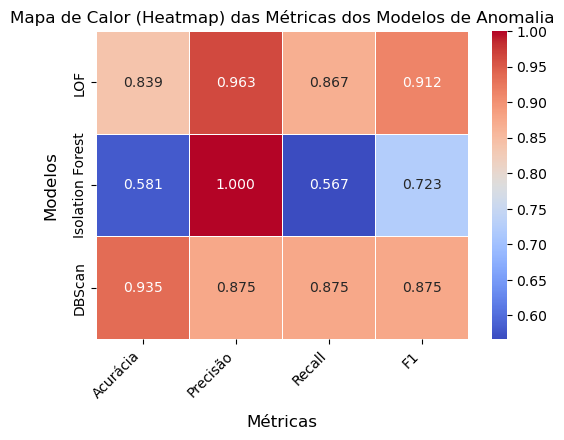

In [41]:
# Dados fornecidos
dados = {
    'Modelo': ['LOF', 'Isolation Forest', 'DBScan'],
    'Acurácia': [accuracy_scores_heatmap[0], accuracy_scores_heatmap[1], accuracy_scores_heatmap[2]],
    'Precisão': [precision_scores_heatmap[0], precision_scores_heatmap[1], precision_scores_heatmap[2]],
    'Recall': [recall_scores_heatmap[0], recall_scores_heatmap[1], recall_scores_heatmap[2]],
    'F1': [f1_scores_heatmap[0], f1_scores_heatmap[1], f1_scores_heatmap[2]]
}

# Crie um DataFrame com os dados
df = pd.DataFrame(dados)

# Reorganize os dados para criar o heatmap
heatmap_data = df.set_index('Modelo')

# Crie o mapa de calor usando o Seaborn
plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=.5, fmt=".3f")

# Defina a legenda no lado inferior
heatmap.set_xlabel("Métricas", labelpad=10, fontsize=12)
heatmap.set_ylabel("Modelos", labelpad=10, fontsize=12)


# Defina as etiquetas das colunas (rótulos horizontais)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('Mapa de Calor (Heatmap) das Métricas dos Modelos de Anomalia')
plt.show()

In [43]:
# Contagem de votos
contagem_anomalia = modelo1 + modelo2 + modelo3
contagem_nao_anomalia = 5 - contagem_anomalia


# Decisão de votação (usando uma maioria simples)
limite_votacao = 3  # Pelo menos 3 modelos devem votar como anomalia
if contagem_anomalia >= limite_votacao:
    decisao_final = "Conjunto de dados anômalo"
else:
    decisao_final = "Conjunto de dados regular"

print("Decisão Final:", decisao_final)


Decisão Final: Conjunto de dados regular
